In [347]:
import sys
sys.path.append("../../")
from datahandling import BcomMEG
import matplotlib.pyplot as plt
import numpy as np
import pywt
import mne
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
epo_files = []
subjects = ['BCOM_18_2']
avoid_reading = True

data = BcomMEG(dir=dir, subjects=subjects, avoid_reading=avoid_reading)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [311]:
re_1_1 = data.data['BCOM_18_2']['re_144'][0][0]
re_to_smooth = re_1_1.get_data()

In [324]:
re_to_smooth.shape

(1, 247, 241)

### Discrete Wavelet Transform

In [92]:
#discrete wavelet transform 
def dwt_denoise(data, wavelet='db4', level=7):
    coefficients = pywt.wavedec(data, wavelet, level=level)
    coefficients[0] = np.zeros_like(coefficients[0]) #d1 #get rid of these two as in Dash et al 2020.
    coefficients[1] = np.zeros_like(coefficients[1]) #d2
    #thresholding - this is not described in the paper but the 7 level doesn't work without it. So, I should ask about this step.
    threshold = np.sqrt(2 * np.log(len(data))) * np.std(coefficients[-1])
    coefficients = [pywt.threshold(c, threshold, mode='soft') for c in coefficients]
    return pywt.waverec(coefficients, wavelet)[:len(data)]


In [93]:
denoized_epochs = np.zeros_like(re_to_smooth)
for epoch_idx in range(re_to_smooth.shape[0]):
    for channel_idx in range(re_to_smooth.shape[1]):
        signal = re_to_smooth[epoch_idx, channel_idx, :]
        denoized_epochs[epoch_idx, channel_idx, :] = dwt_denoise(signal, wavelet='db4', level=7)



/opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


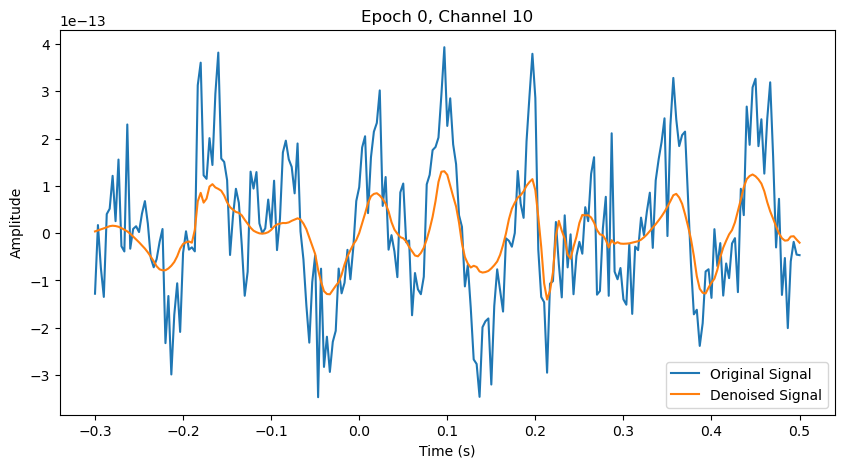

In [253]:
epoch_idx = 0  # Select an epoch
channel_idx = 10  # Select a channel

plt.figure(figsize=(10, 5))
plt.plot(re_1_1.times, re_to_smooth[epoch_idx, channel_idx, :], label="Original Signal")
plt.plot(re_1_1.times, denoized_epochs[epoch_idx, channel_idx, :], label="Denoised Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title(f"Epoch {epoch_idx}, Channel {channel_idx}")
plt.show()

### Continuous Wavelet transform

In [337]:
def scalogram_reconstruction(data, wavelet='db4', level=7):
    # First decompose
    coefficients = pywt.wavedec(data, wavelet, level=level)

    # Then, modify coefficients to reconstruct back to second level
    modified_coefficients = list(coefficients)

    # Zero out after second level
    for i in range(2, len(coefficients)):
        modified_coefficients[i] = np.zeros_like(coefficients[i])
    
    # Reconstruct
    reconstructed_signal = pywt.waverec(modified_coefficients, wavelet)[:len(data)]

    return reconstructed_signal

def scalogram_cwt(processed_data, fs):
    # define the frequencies
    frequencies = np.logspace(np.log10(1), np.log10(fs/2), 50)

    # calculate sclaes
    scales = pywt.central_frequency(wavelet='morl') * fs / frequencies

    # perfrom the cwt
    coefficients, _ = pywt.cwt(processed_data, scales, wavelet='morl')

    return coefficients, frequencies



In [338]:
processed_epochs = np.zeros_like(re_to_smooth)
for epoch_idx in range(re_to_smooth.shape[0]):
    for channel_idx in range(re_to_smooth.shape[1]):
        signal = re_to_smooth[epoch_idx, channel_idx, :]
        processed_epochs[epoch_idx, channel_idx, :] = scalogram_reconstruction(signal, wavelet='db4', level=4)

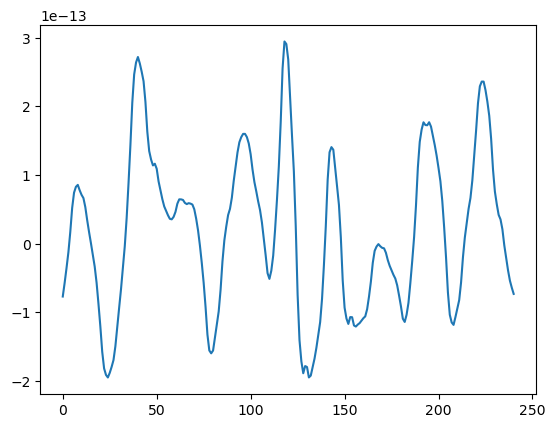

In [314]:
plt.plot(processed_epochs[0, 0, :])

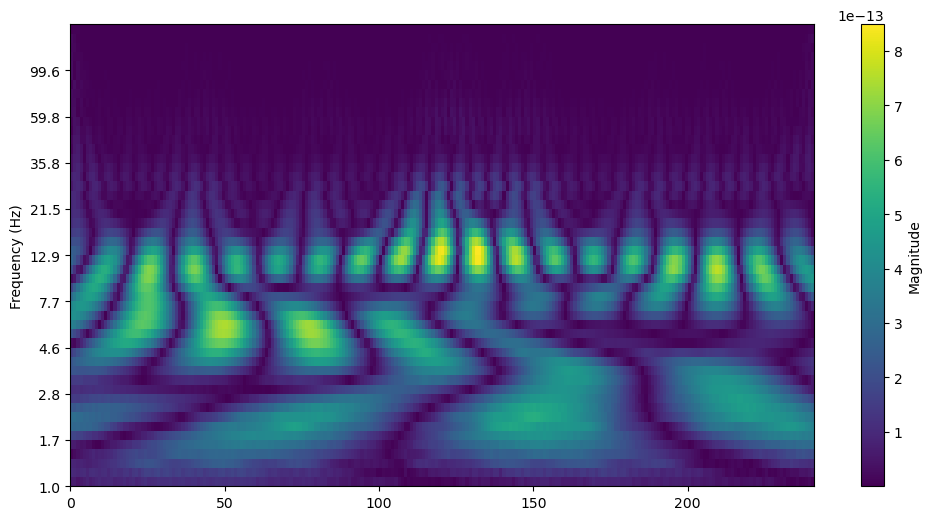

In [339]:
coefficients, frequencies = scalogram_cwt(processed_epochs[0, 0, :], fs=300)
plt.figure(figsize=(12, 6))
plt.pcolormesh(np.abs(coefficients), cmap='viridis')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.arange(len(frequencies))[::5], 
          np.round(frequencies[::5], 1))  # Show every 5th frequency
plt.colorbar(label='Magnitude')
plt.show()

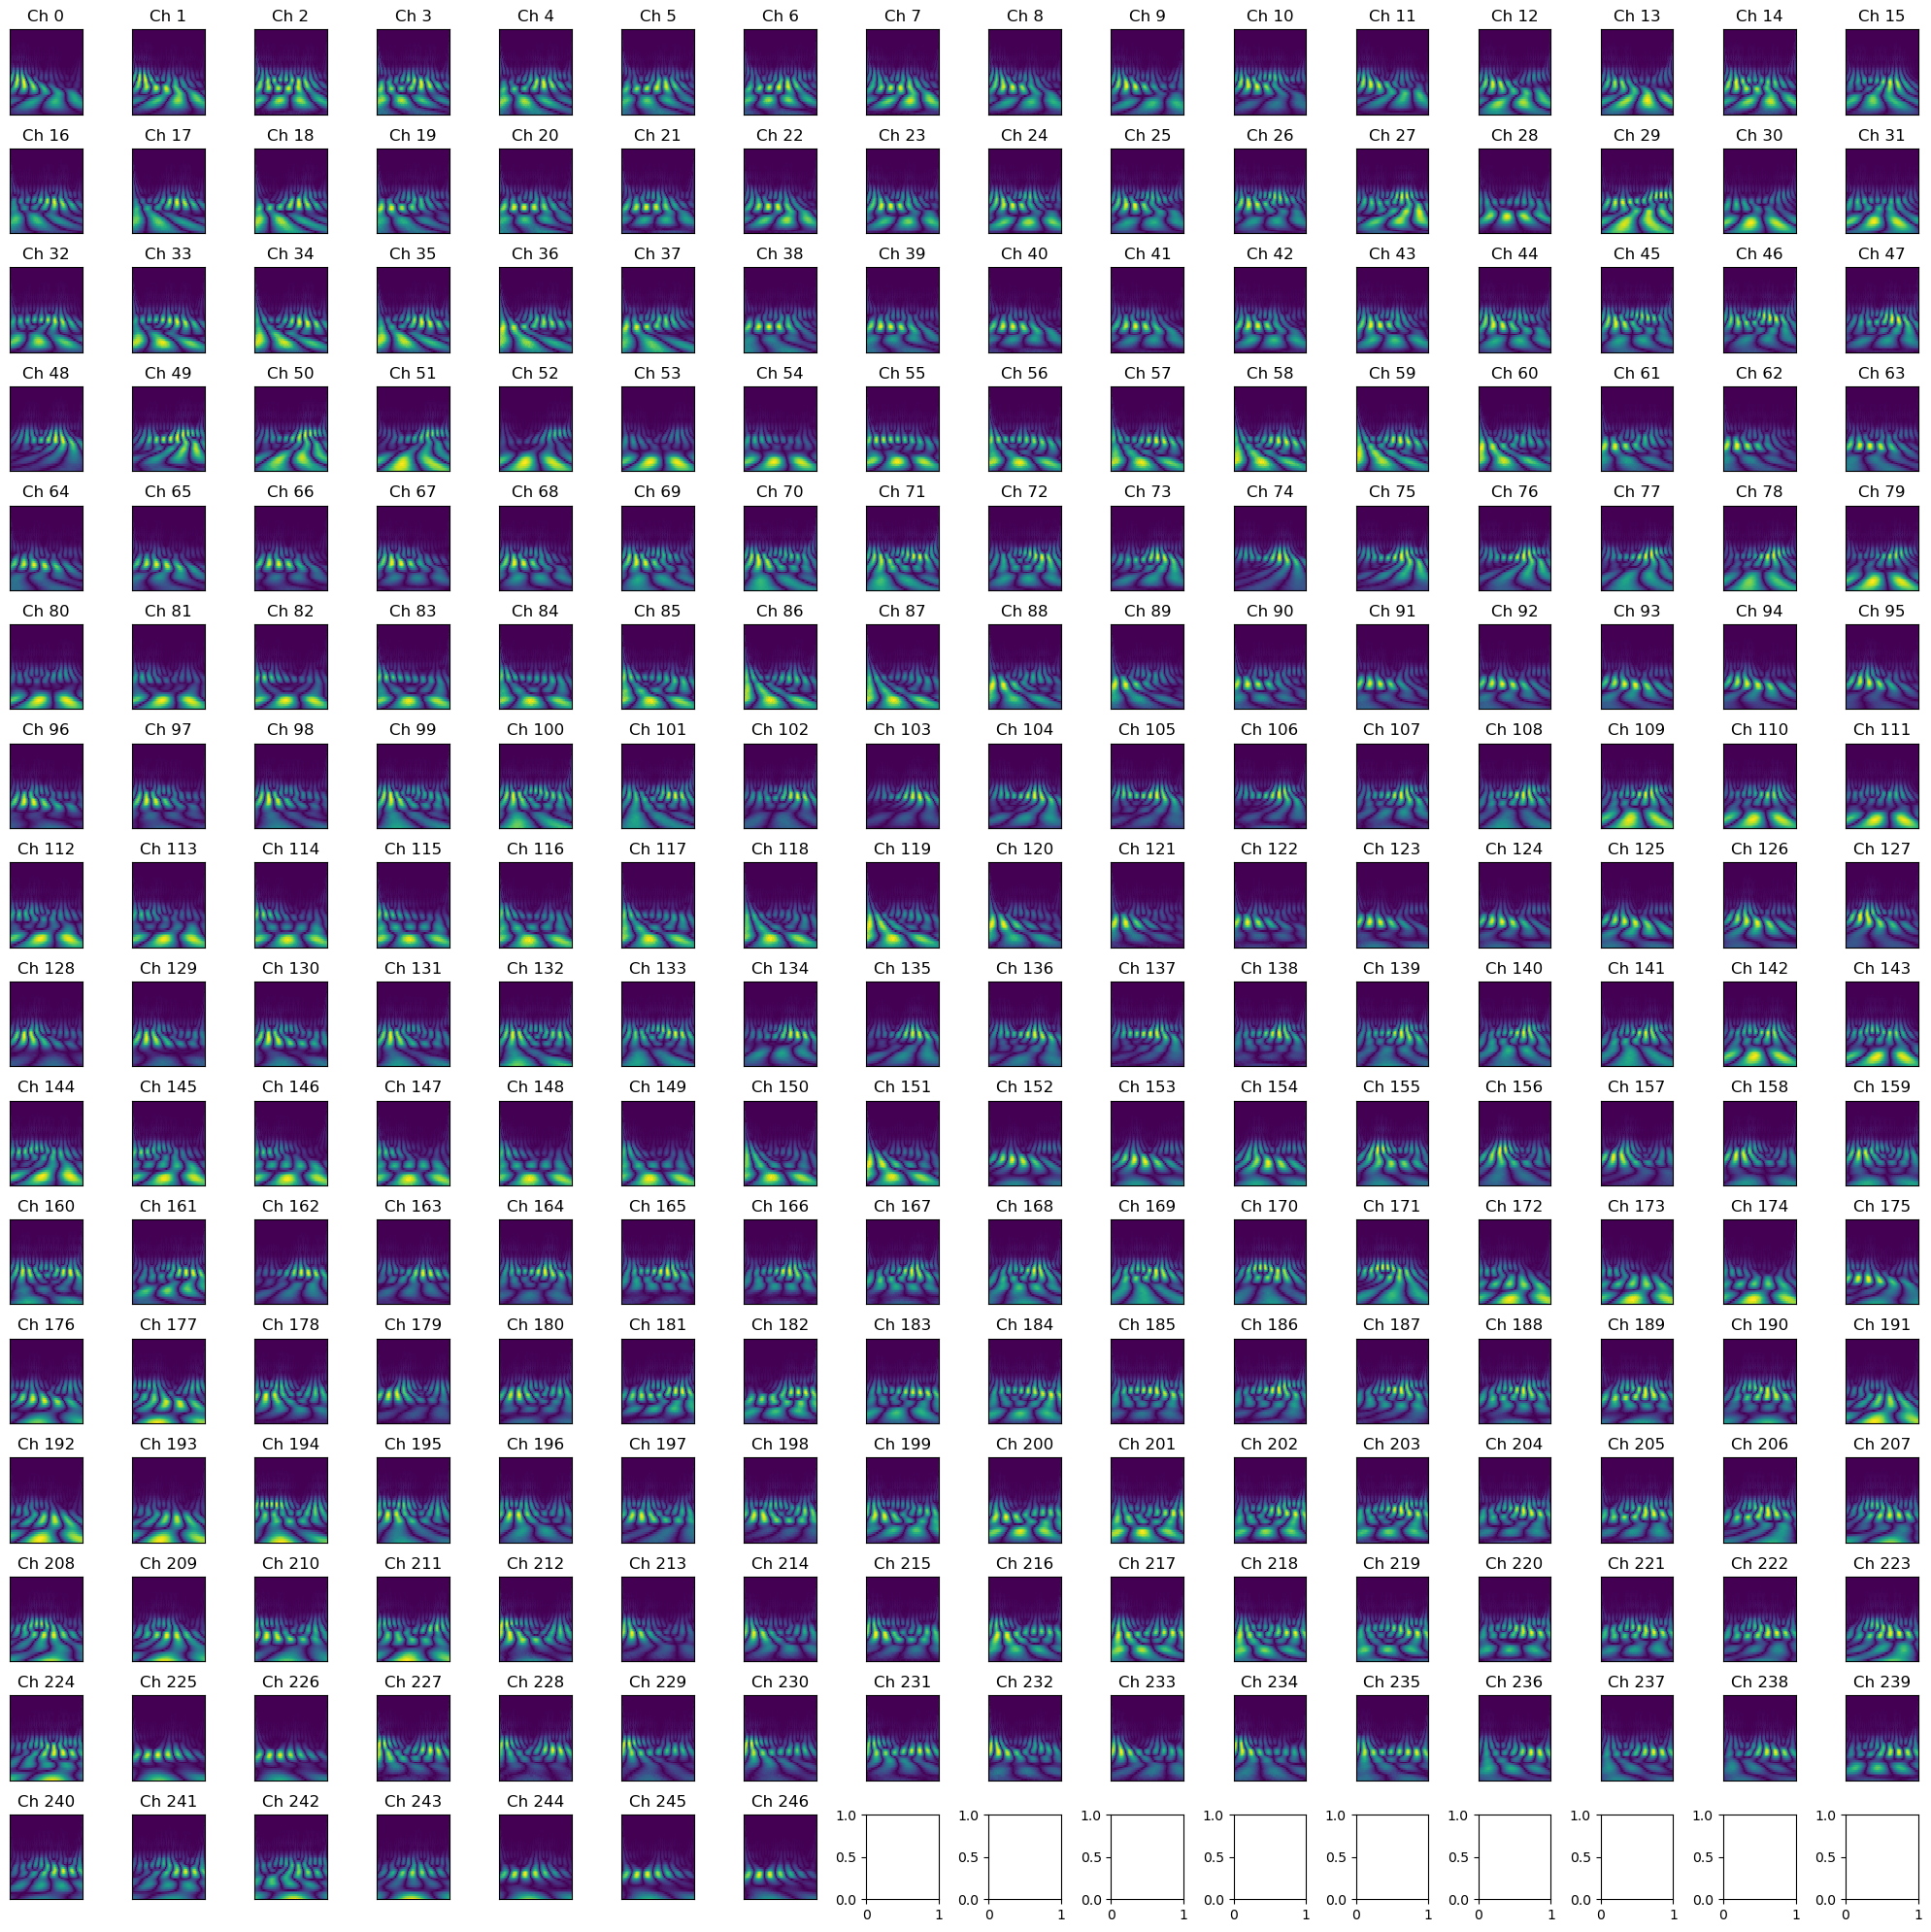

In [341]:
# lets see the entire brain for the first epoch
# re_to_smooth.shape (1, 247, 241)
fig, axes = plt.subplots(16, 16, figsize=(20, 20))
for idx in range(re_to_smooth.shape[1]):
        r, c = divmod(idx, 16)
        signal = re_to_smooth[0, idx, :]
        processed_epochs[0, idx, :] = scalogram_reconstruction(signal, wavelet='db4', level=5)
        coefficients, frequencies = scalogram_cwt(processed_epochs[0, idx, :], fs=300)
        axes[r, c].pcolormesh(np.abs(coefficients), cmap='viridis')
        axes[r, c].set_title(f"Ch {idx}")
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
plt.tight_layout()
plt.show()
    


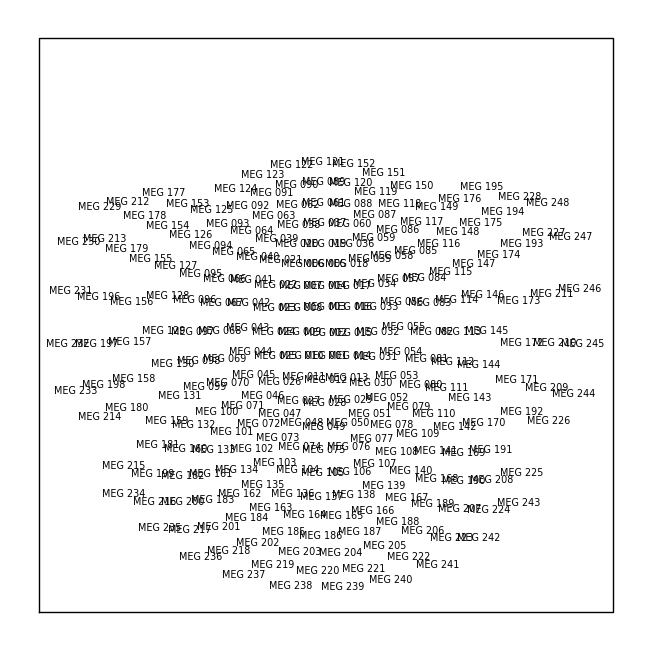

In [382]:
# get the layouts like in Deffosez et al. 
mne.find_layout(re_1_1.info, ch_type="meg").plot()
picks = mne.pick_types(re_1_1.info, meg=True, eeg=False, eog=False, stim=False)
sensor_coords = np.array([re_1_1.info['chs'][p]['loc'][:3] for p in picks])

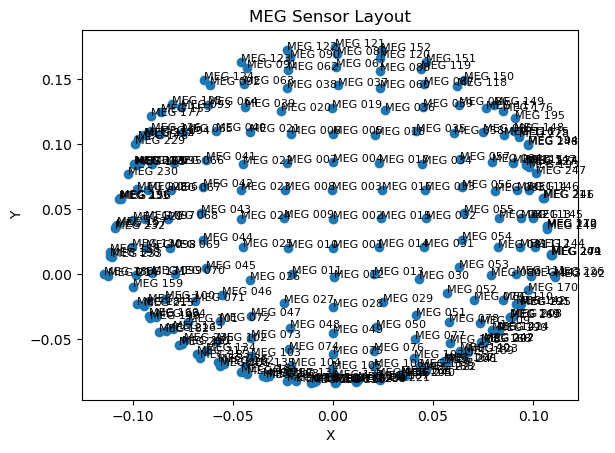

In [387]:
plt.scatter(sensor_coords[:, 0], sensor_coords[:, 1])
for i, coord in enumerate(sensor_coords):
    plt.text(coord[0], coord[1], re_1_1.info['ch_names'][picks[i]], fontsize=8)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('MEG Sensor Layout')
plt.show()